# PCA Demo

Much of the code was taken from https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


In [1]:
# Necessary imports
import numpy as np #package for work with arrays and matrices
import matplotlib.pyplot as plt #package with plotting capabilities
import seaborn as sns; sns.set() # colors for visualization
from sklearn.decomposition import PCA # Principal component analysis

## Example with two variable data

Let us generate a set of 200 data points with two variables and plot them in the plane:

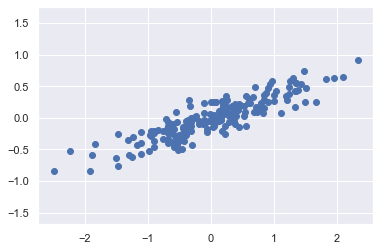

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Below we perform Principal Component Analysis using the scikit-learn function PCA and print out the two components and how much variance is explained by each:

In [4]:
pca = PCA(n_components=2)
pca.fit(X) # apply PCA to the data set X
print(pca.components_)
print(pca.explained_variance_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


Now we visualize the two principal components as vectors in the plane scaled by the amount of variance captured by each one:

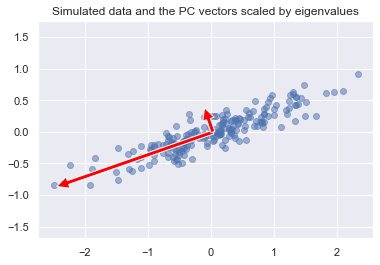

In [5]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    ax.annotate('', v1, v0, arrowprops=dict(facecolor = 'red'))

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal') # this ensures that the axes are not scaled so you can see the PCs are actually orthogonal
plt.title('Simulated data and the PC vectors scaled by eigenvalues')
plt.show()

Next step is to reduce the number of dimensions of the data from 2 to 1 by *projecting* the data onto the main principal component (the one with the highest amount of variance):

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


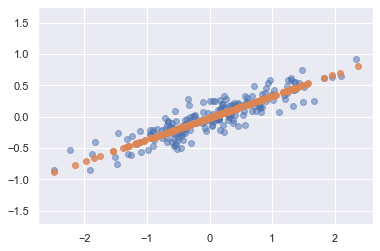

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The green points are the data points projected onto the first principal component. The information from the orthogonal second principal component is lost, but this is the most efficient way of compressing two dimensions into 1.

## Application to image classification

The following uses a data set of images of hand-written digits, which are represented in 8 by 8 arrays of black or white pixels. Each digit also has information about its inteded meaning (called the 'target'). The figure below shows an image and its target value (7). 

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

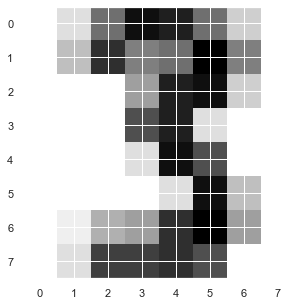

3


In [10]:
plt.figure(1, figsize=(5, 5))
plt.imshow(digits.images[13], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()
print(digits.target[13])

PCA uses the covariance structure of the data to find the most optimal directions in the variable space. The following code visualizes the correlation matrix (which is a normalized covariance) of the data set of digit images.

/Users/dmitry/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/dmitry/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


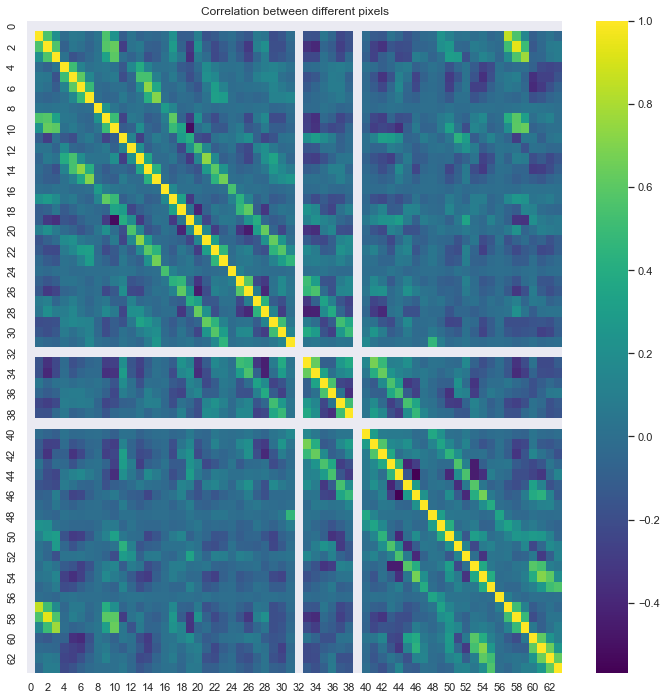

In [11]:
correlation = np.corrcoef(digits.data, rowvar=False)
plt.figure(figsize=(12,12))
sns.heatmap(correlation, vmax=1,  cmap='viridis')

plt.title('Correlation between different pixels')
plt.show()

To see how much of the information is contained in each principal component, we can plot the individual values, to see how the information captured by each successive one decreases, and then see the cumulative variance explained by each one. It shows that the first 10 PCs contain more than 75% of the variance of the data, while reducing the number of variables by more than a factor of 6!

(64,)


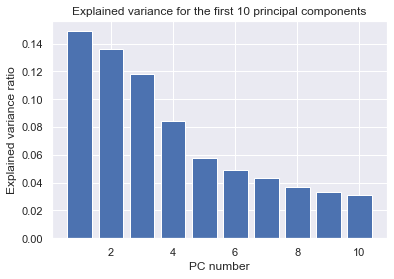

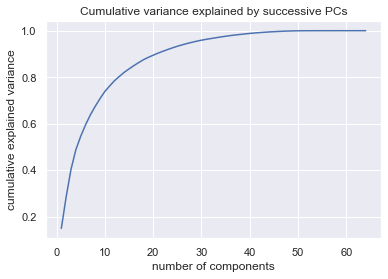

In [12]:
pca = PCA()
pca.fit_transform(digits.data)
explained_variance=pca.explained_variance_ratio_
print(explained_variance.shape)

plt.bar(1+np.arange(10),explained_variance[np.arange(10)], align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('PC number')
plt.title('Explained variance for the first 10 principal components')
plt.show()

pca = PCA().fit(digits.data)
plt.plot(1+np.arange(64), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative variance explained by successive PCs')
plt.show()

We can use PCA to project the images (which are really 64-dimensional vectors of pixels) into the plane of the first two principal components. Each point represents a single image, and the color corresponds to the digit it is meant to represent.

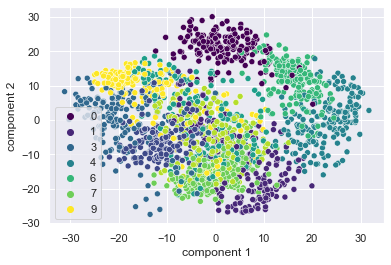

In [13]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1],
            hue=digits.target, palette="viridis")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

### Reconstructing data from principal components

We plotted the data in the simplified space of principal components, but now let's see if what the digits look like if we reconstruct the images from some number of principal components. First, here is a handy function to plot an array of images: 

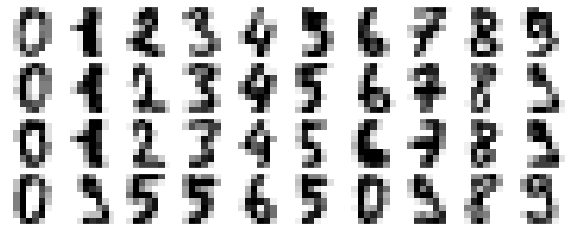

In [14]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now let's take the first two PCs and use inverse_transform to reconstruct the images. You can see that they have the same vague shapes but look very smeared compared to the original:

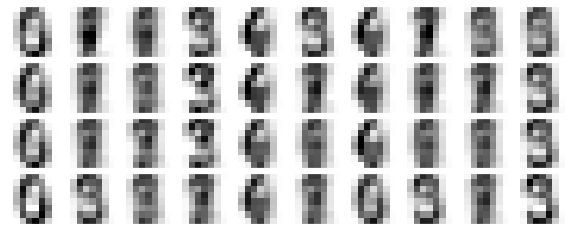

In [15]:
pca = PCA(2).fit(digits.data)
components = pca.transform(digits.data)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

Now we take the first 5 PCs and see how well they do:

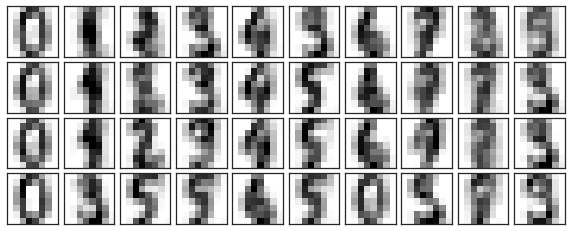

In [54]:
pca = PCA(5).fit(digits.data)
components = pca.transform(digits.data)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

Finally, we take the first 32 (half of all PCs) and see that they reconstruct the original images almost exactly:

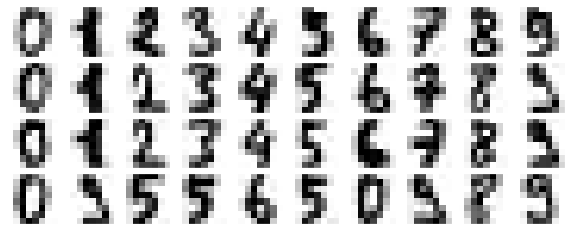

In [16]:
pca = PCA(32).fit(digits.data)
components = pca.transform(digits.data)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

The following function from https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html shows the sequential reconstruction of an image by adding more PCs:

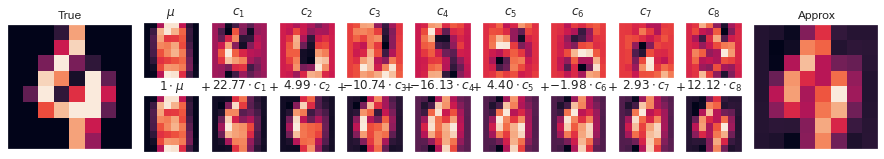

In [17]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx,
             r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

pca = PCA(n_components=8)
Xproj = pca.fit_transform(digits.data)
#sns.set_style('white')
fig = plot_pca_components(digits.data[100], Xproj[100],
                          pca.mean_, pca.components_)
